In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/thesis-data/Nebuli_data.csv
/kaggle/input/thesis-data/preprocessed_nlp_data.csv


In [2]:
!pip install --upgrade nltk
!pip install hdbscan
!pip install dash_bio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.2 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 49.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 49.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.6 MB/s eta 0:00:00
  Preparing met

In [3]:
import pandas as pd
import numpy as np
from plotly import graph_objs as go
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import nltk
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer, PorterStemmer
# from sklearn.feature_extraction.text import TfidfVectorizer
# dler = nltk.downloader.Downloader()
# dler._update_index()
nltk.data.path.append('/kaggle/output')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.corpus import  wordnet

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
data_df = pd.read_csv('/kaggle/input/thesis-data/Nebuli_data.csv',index_col=0)
data_df.head()

id                                              title  \
0  201               SGI Launches Open Storage Initiative   
1  270  IBM Releases Next Generation Storage Virtualis...   
2  293  IBM Launches New Mainframe and Storage Systems...   
3  337  Oracle 10g database sets the pace for a world ...   
4  339   IBM Releases New Automated DB2 Database Software   

                                           introtext  \
0  Silicon Graphics has today announced the Open ...   
1  IBM has revealed its TotalStorage SAN File Sys...   
2  Celebrating the 40th anniversary of the IBM Sy...   
3  Oracle is setting the pace for the highest per...   
4  IBM has today announced the release of its new...   

                                            fulltext  cat_id          class_2  \
0  Silicon Graphics has today announced the Open ...    1836  Data Management   
1  IBM has revealed its TotalStorage SAN File Sys...    1836  Data Management   
2   Celebrating the 40th anniversary of the IBM S...    1836  Data Management   
3   Tests were performed on an eight-node cluster...    1836  Data Management   
4   The new database software promises to deliver...    1836  Data Management   

   level  cat_parent_id parent_title  grandparent_id grandparent_title  
0      3           2100     Big Data            2096          Channels  
1      3           2100     Big Data            2096          Channels  
2      3           2100     Big Data            2096          Channels  
3      3           2100     Big Data            2096          Channels  
4      3           2100     Big Data            2096          Channels

In [5]:
len(data_df.id.unique())

9413

In [6]:
data_df.isnull().sum()

id                     0
title                  0
introtext            378
fulltext             259
cat_id                 0
class_2                0
level                  0
cat_parent_id          0
parent_title           0
grandparent_id         0
grandparent_title      0
dtype: int64

In [7]:
data_df = data_df[data_df['fulltext'].isnull()==False]
len(data_df[data_df.isnull()==False])

9154

In [8]:
data_df.isnull().sum()

id                     0
title                  0
introtext            378
fulltext               0
cat_id                 0
class_2                0
level                  0
cat_parent_id          0
parent_title           0
grandparent_id         0
grandparent_title      0
dtype: int64

In [9]:
k = data_df.groupby(['parent_title']).agg({'id':'count'}).reset_index()
fig = px.bar(k, y="parent_title",x='id')
fig.show()

In [10]:
data_df.loc[data_df['parent_title'] == 'Channels', 'parent_title'] = data_df['class_2']
data_df.loc[data_df['cat_parent_id'] == '2096', 'cat_parent_id'] = data_df['cat_id']
data_df.parent_title.unique(),len(data_df.parent_title.unique())

(array(['Big Data', 'Nanotechnology', 'Alternative Energy', 'Bio-IT',
        'Healthcare Technology', 'Genomics', 'Clinical Research',
        'Disease Processes', 'Cancer Research', 'Bioengineering',
        'Green Biology', 'Proteomics', 'Stem Cells', 'Neuroscience',
        'Material Science', 'Cell Biology', 'Food Bioscience',
        'Biopollution', 'Social Science', 'Astrobiology'], dtype=object),
 20)

In [11]:
k = data_df.groupby(['parent_title']).agg({'id':'count'}).reset_index()
k = k[k['id']>50]
fig = px.bar(k, y="parent_title",x='id')
data_df = data_df[data_df['parent_title'].isin(k.parent_title.unique())]
fig.show()

In [12]:
data_df.parent_title.unique(),len(data_df.parent_title.unique())

(array(['Big Data', 'Nanotechnology', 'Alternative Energy', 'Bio-IT',
        'Healthcare Technology', 'Genomics', 'Clinical Research',
        'Disease Processes', 'Cancer Research', 'Bioengineering',
        'Green Biology', 'Proteomics', 'Stem Cells', 'Neuroscience',
        'Material Science', 'Cell Biology', 'Food Bioscience',
        'Biopollution'], dtype=object),
 18)

In [13]:
def preprocess_text(text):
    # Tokenization
    text= ''.join(e for e in text if e.isalnum() or e in {' ','\n'})
    tokens = nltk.word_tokenize(text.lower())

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
#     lemmatizer = WordNetLemmatizer()
#     tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = [PorterStemmer().stem(token) for token in tokens]
    # Join the tokens back into a single string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

data_df['title_cleaned'] = data_df['title'].apply(preprocess_text)
data_df['introtext'] = data_df['introtext'].astype(str)
data_df['introtext_cleaned'] =data_df['introtext'].apply(preprocess_text)
data_df['fulltext'] = data_df['fulltext'].astype(str)
data_df['fulltext_cleaned'] =data_df['fulltext'].apply(preprocess_text)
data_df.to_csv('preprocessed_nlp_data.csv')
data_df.head()

id                                              title  \
0  201               SGI Launches Open Storage Initiative   
1  270  IBM Releases Next Generation Storage Virtualis...   
2  293  IBM Launches New Mainframe and Storage Systems...   
3  337  Oracle 10g database sets the pace for a world ...   
4  339   IBM Releases New Automated DB2 Database Software   

                                           introtext  \
0  Silicon Graphics has today announced the Open ...   
1  IBM has revealed its TotalStorage SAN File Sys...   
2  Celebrating the 40th anniversary of the IBM Sy...   
3  Oracle is setting the pace for the highest per...   
4  IBM has today announced the release of its new...   

                                            fulltext  cat_id          class_2  \
0  Silicon Graphics has today announced the Open ...    1836  Data Management   
1  IBM has revealed its TotalStorage SAN File Sys...    1836  Data Management   
2   Celebrating the 40th anniversary of the IBM S...    1836  Data Management   
3   Tests were performed on an eight-node cluster...    1836  Data Management   
4   The new database software promises to deliver...    1836  Data Management   

   level  cat_parent_id parent_title  grandparent_id grandparent_title  \
0      3           2100     Big Data            2096          Channels   
1      3           2100     Big Data            2096          Channels   
2      3           2100     Big Data            2096          Channels   
3      3           2100     Big Data            2096          Channels   
4      3           2100     Big Data            2096          Channels   

                                       title_cleaned  \
0                       sgi launch open storag initi   
1  ibm releas next gener storag virtualis softwar...   
2  ibm launch new mainfram storag system celebr 4...   
3    oracl 10g databas set pace world record perform   
4           ibm releas new autom db2 databas softwar   

                                   introtext_cleaned  \
0  silicon graphic today announc open storag init...   
1  ibm reveal totalstorag san file system softwar...   
2  celebr 40th anniversari ibm system360 mainfram...   
3  oracl set pace highest perform oracl databas 1...   
4  ibm today announc releas new db2 univers datab...   

                                    fulltext_cleaned  
0  silicon graphic today announc open storag init...  
1  ibm reveal totalstorag san file system softwar...  
2  celebr 40th anniversari ibm system360 mainfram...  
3  test perform eightnod cluster industrystandard...  
4  new databas softwar promis deliv number key im...

In [14]:
data_df = data_df.reset_index(drop=True)
len(data_df)

9150

In [15]:
nlp_df = pd.read_csv('/kaggle/input/thesis-data/preprocessed_nlp_data.csv',index_col=0)
nlp_df.head()

id                                              title  \
0  201               SGI Launches Open Storage Initiative   
1  270  IBM Releases Next Generation Storage Virtualis...   
2  293  IBM Launches New Mainframe and Storage Systems...   
3  337  Oracle 10g database sets the pace for a world ...   
4  339   IBM Releases New Automated DB2 Database Software   

                                           introtext  \
0  Silicon Graphics has today announced the Open ...   
1  IBM has revealed its TotalStorage SAN File Sys...   
2  Celebrating the 40th anniversary of the IBM Sy...   
3  Oracle is setting the pace for the highest per...   
4  IBM has today announced the release of its new...   

                                            fulltext  cat_id          class_2  \
0  Silicon Graphics has today announced the Open ...    1836  Data Management   
1  IBM has revealed its TotalStorage SAN File Sys...    1836  Data Management   
2   Celebrating the 40th anniversary of the IBM S...    1836  Data Management   
3   Tests were performed on an eight-node cluster...    1836  Data Management   
4   The new database software promises to deliver...    1836  Data Management   

   level  cat_parent_id parent_title  grandparent_id grandparent_title  \
0      3           2100     Big Data            2096          Channels   
1      3           2100     Big Data            2096          Channels   
2      3           2100     Big Data            2096          Channels   
3      3           2100     Big Data            2096          Channels   
4      3           2100     Big Data            2096          Channels   

                                       title_cleaned  \
0                       sgi launch open storag initi   
1  ibm releas next gener storag virtualis softwar...   
2  ibm launch new mainfram storag system celebr 4...   
3    oracl 10g databas set pace world record perform   
4           ibm releas new autom db2 databas softwar   

                                   introtext_cleaned  \
0  silicon graphic today announc open storag init...   
1  ibm reveal totalstorag san file system softwar...   
2  celebr 40th anniversari ibm system360 mainfram...   
3  oracl set pace highest perform oracl databas 1...   
4  ibm today announc releas new db2 univers datab...   

                                    fulltext_cleaned  
0  silicon graphic today announc open storag init...  
1  ibm reveal totalstorag san file system softwar...  
2  celebr 40th anniversari ibm system360 mainfram...  
3  test perform eightnod cluster industrystandard...  
4  new databas softwar promis deliv number key im...

In [16]:
nlp_df[['fulltext','fulltext_cleaned']]

fulltext  \
0     Silicon Graphics has today announced the Open ...   
1     IBM has revealed its TotalStorage SAN File Sys...   
2      Celebrating the 40th anniversary of the IBM S...   
3      Tests were performed on an eight-node cluster...   
4      The new database software promises to deliver...   
...                                                 ...   
9408   &nbsp; The LeapFish search experience gives u...   
9409   The research, led by Sergey Gavrilets, associ...   
9410   Graham Ryland and Professor Harry Cheng hope ...   
9411       The University of Sussex-led study - fund...   
9412       SpaceX's Dragon spacecraft is delivering ...   

                                       fulltext_cleaned  
0     silicon graphic today announc open storag init...  
1     ibm reveal totalstorag san file system softwar...  
2     celebr 40th anniversari ibm system360 mainfram...  
3     test perform eightnod cluster industrystandard...  
4     new databas softwar promis deliv number key im...  
...                                                 ...  
9408  nbsp leapfish search experi give user abil man...  
9409  research led sergey gavrilet associ director s...  
9410  graham ryland professor harri cheng hope imobo...  
9411  univers sussexl studi fund nokia research cent...  
9412  spacex dragon spacecraft deliv almost 7000 pou...  

[9413 rows x 2 columns]

In [17]:
feature_names_list = []
bag_nlp_df = data_df.copy(deep=True)
vectorizer = CountVectorizer()
bag_of_words = vectorizer.fit_transform(bag_nlp_df['fulltext_cleaned'].values.astype('U'))
feature_names = vectorizer.get_feature_names_out()
bow_df = pd.DataFrame(bag_of_words.toarray(), columns=feature_names)
bag_nlp_df = pd.concat([bag_nlp_df, bow_df], axis=1)
feature_names_list.extend(feature_names)
bag_nlp_df.tail()

id                                              title  \
9145   9482  Researchers Revealed New Method for Making Ela...   
9146   9515                     Origami Used to Create Battery   
9147  10957  Researchers Are a Step Closer Towards New, Fas...   
9148   3568                           Scientists Invent iMobot   
9149  10963    Research Brings 'Smart Hands' Closer to Reality   

                                              introtext  \
9145  Stockholm, Sweden (Scicasts) Â A method for m...   
9146  Binghamton, NY (Scicasts) Â Origami, the Japa...   
9147  Washington, DC (Scicasts) Â Researchers found...   
9148  Davis, CA (Scicasts) Â Scientists at the Univ...   
9149  Brighton, UK (Scicasts) Â Using your skin as ...   

                                               fulltext  cat_id  \
9145   Using nanocellulose broken down from tree fib...    2139   
9146   Seokheun Sean Choi developed an inexpensive, ...    2139   
9147      In this research, the internal gaps in the...    2139   
9148   Graham Ryland and Professor Harry Cheng hope ...    2149   
9149       The University of Sussex-led study - fund...    2149   

             class_2  level  cat_parent_id        parent_title  \
9145  Battery Energy      3           2128  Alternative Energy   
9146  Battery Energy      3           2128  Alternative Energy   
9147  Battery Energy      3           2128  Alternative Energy   
9148     Biorobotics      3           2093      Bioengineering   
9149     Biorobotics      3           2093      Bioengineering   

      grandparent_id  ... ãsa ãscar ãse ãsecretase1  ãslaug  ãthe  ãverkalix  \
9145            2096  ...   0     0   0           0       0     0          0   
9146            2096  ...   0     0   0           0       0     0          0   
9147            2096  ...   0     0   0           0       0     0          0   
9148            2096  ...   0     0   0           0       0     0          0   
9149            2096  ...   0     0   0           0       0     0          0   

      ãystein  ãzer  ãzge  
9145        0     0     0  
9146        0     0     0  
9147        0     0     0  
9148        0     0     0  
9149        0     0     0  

[5 rows x 106532 columns]

In [18]:
len(bow_df)

9150

In [19]:
df_bow_sklearn = pd.DataFrame(bag_of_words.toarray(),columns=feature_names)

8089


(array([1.06027e+05, 2.77000e+02, 1.09000e+02, 4.80000e+01, 3.20000e+01,
        1.10000e+01, 8.00000e+00, 3.00000e+00, 2.00000e+00, 1.00000e+00]),
 array([1.0000e+00, 8.0980e+02, 1.6186e+03, 2.4274e+03, 3.2362e+03,
        4.0450e+03, 4.8538e+03, 5.6626e+03, 6.4714e+03, 7.2802e+03,
        8.0890e+03]),
 <BarContainer object of 10 artists>)

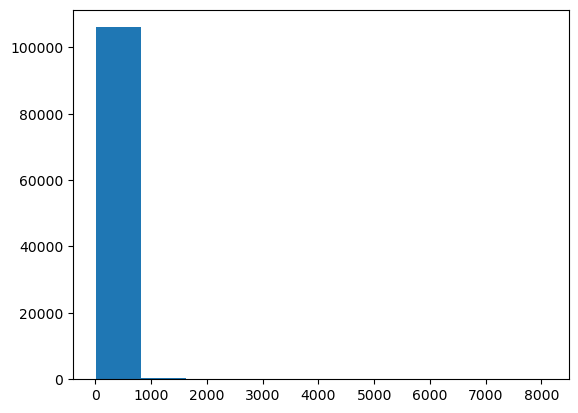

In [20]:
print(max(df_bow_sklearn.astype('bool').sum()))
series = df_bow_sklearn.astype('bool').sum(axis=0)
plt.hist(series)

(array([207.,  96.,  51.,  25.,  28.,  12.,   6.,   3.,   3.,   2.]),
 array([ 904. , 1522.6, 2141.2, 2759.8, 3378.4, 3997. , 4615.6, 5234.2,
        5852.8, 6471.4, 7090. ]),
 <BarContainer object of 10 artists>)

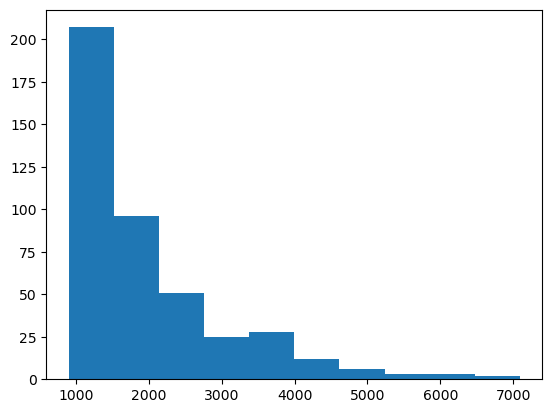

In [21]:
df_bow_sklearn = df_bow_sklearn.loc[:, (df_bow_sklearn.astype('bool').sum() >= 900) & (df_bow_sklearn.astype('bool').sum() <= 8000)]
df_bow_sklearn = df_bow_sklearn.loc[:, ~df_bow_sklearn.columns.str.contains(r'\d')]
series = df_bow_sklearn.astype('bool').sum(axis=0)
plt.hist(series)

In [22]:
df_bow_sklearn.shape,bag_nlp_df.shape

((9150, 433), (9150, 106532))

In [23]:
df_bow_sklearn.head()

abil  abl  accord  across  act  activ  actual  ad  adapt  addit  ...  wide  \
0     0    0       1       0    0      0       0   1      0      0  ...     0   
1     0    0       1       1    0      0       0   0      0      3  ...     1   
2     0    0       2       0    0      0       0   0      0      1  ...     0   
3     0    0       0       0    0      0       0   0      0      1  ...     0   
4     0    0       0       2    0      0       0   0      0      0  ...     0   

   within  without  work  world  would  year  yet  âthe  âwe  
0       0        3     0      0      0     0    0     0    0  
1       0        1     0      1      0     1    0     0    0  
2       0        0     0      0      0     0    0     0    0  
3       0        0     0      2      0     0    0     0    0  
4       0        0     0      0      0     0    0     0    0  

[5 rows x 433 columns]

In [24]:
bag_nlp_df = pd.concat([data_df[['cat_id','cat_parent_id','grandparent_id']], df_bow_sklearn], axis=1)
bag_nlp_df.shape

(9150, 436)

In [25]:
bag_nlp_df.tail()

cat_id  cat_parent_id  grandparent_id  abil  abl  accord  across  act  \
9145    2139           2128            2096     0    0       0       0    0   
9146    2139           2128            2096     0    0       0       0    0   
9147    2139           2128            2096     0    0       0       0    0   
9148    2149           2093            2096     0    0       0       0    0   
9149    2149           2093            2096     1    0       0       0    0   

      activ  actual  ...  wide  within  without  work  world  would  year  \
9145      0       0  ...     0       2        2     0      0      1     0   
9146      0       1  ...     0       0        0     4      1      1     1   
9147      0       0  ...     0       0        0     0      0      1     0   
9148      0       0  ...     0       0        1     0      0      0     1   
9149      0       0  ...     0       0        0     1      0      0     0   

      yet  âthe  âwe  
9145    0     0    0  
9146    0     0    0  
9147    0     0    0  
9148    0     0    0  
9149    0     0    0  

[5 rows x 436 columns]

In [26]:
bag_nlp_df.to_csv('temp.csv')

In [27]:
bag_nlp_df.isnull().sum()

cat_id            0
cat_parent_id     0
grandparent_id    0
abil              0
abl               0
                 ..
would             0
year              0
yet               0
âthe              0
âwe               0
Length: 436, dtype: int64

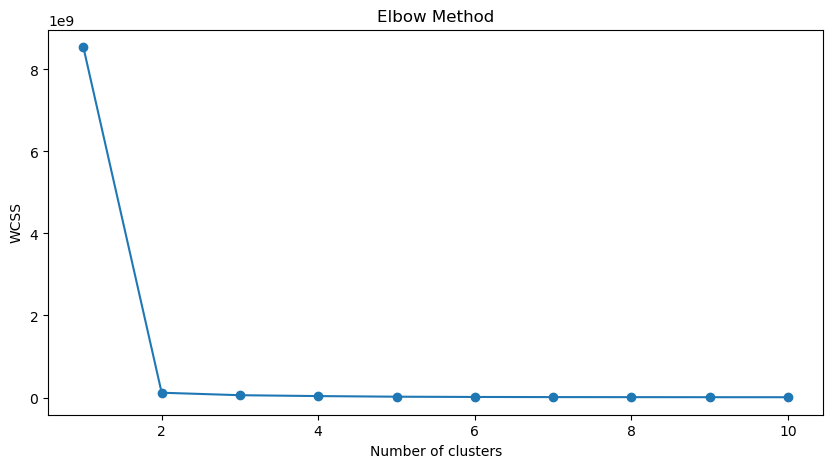

In [28]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
X = bag_nlp_df
wcss = []
K_range = range(1, 11)
for i in K_range:
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize=(10,5))
plt.plot(K_range, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [29]:
import numpy as np
import plotly.express as px
from sklearn import datasets
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
import hdbscan

n_samples = 1500
random_state = 170
X = bag_nlp_df

methods = {
    "KMeans": KMeans(n_clusters=2),
    "SpectralClustering": SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans'),
    "Hierarchical": AgglomerativeClustering(n_clusters=10),
    "DBSCAN": DBSCAN(eps=0.1),
    "HDBSCAN": hdbscan.HDBSCAN(min_cluster_size=2)
}

results = {}

for name, method in methods.items():
    results[name] = method.fit_predict(X)
    
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_data = tsne.fit_transform(X)

for name, labels in results.items():
    fig = px.scatter(reduced_data, color=labels, title=name)
    fig.show()

In [30]:
reduced_data

array([[-60.12556  , -34.816177 ],
       [-60.12939  , -34.785915 ],
       [-60.176548 , -34.829937 ],
       ...,
       [ -5.1987433,  76.43339  ],
       [-38.42727  ,  20.769123 ],
       [-38.429268 ,  20.768757 ]], dtype=float32)

In [31]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
silhouette = silhouette_score(reduced_data, results['KMeans'])
davies_bouldin = davies_bouldin_score(reduced_data,results['KMeans'])
calinski_harabasz = calinski_harabasz_score(reduced_data, results['KMeans'])

silhouette,davies_bouldin, calinski_harabasz

(0.26184157, 1.2644800498322117, 3052.2785360397434)

In [32]:
silhouette = silhouette_score(reduced_data, results['SpectralClustering'])
davies_bouldin = davies_bouldin_score(reduced_data,results['SpectralClustering'])
calinski_harabasz = calinski_harabasz_score(reduced_data, results['SpectralClustering'])

silhouette,davies_bouldin, calinski_harabasz

(0.08580607, 3.8201011326584333, 451.85534434506195)

In [33]:
silhouette = silhouette_score(reduced_data, results['Hierarchical'])
davies_bouldin = davies_bouldin_score(reduced_data,results['Hierarchical'])
calinski_harabasz = calinski_harabasz_score(reduced_data, results['Hierarchical'])

silhouette,davies_bouldin, calinski_harabasz

(0.28093848, 3.167817842353899, 2750.8378143405644)

In [34]:
#silhouette = silhouette_score(reduced_data, results['DBSCAN'])
#davies_bouldin = davies_bouldin_score(reduced_data,results['DBSCAN'])
#calinski_harabasz = calinski_harabasz_score(reduced_data, results['DBSCAN'])

#silhouette,davies_bouldin, calinski_harabasz

In [35]:
silhouette = silhouette_score(reduced_data, results['HDBSCAN'])
davies_bouldin = davies_bouldin_score(reduced_data,results['HDBSCAN'])
calinski_harabasz = calinski_harabasz_score(reduced_data, results['HDBSCAN'])

silhouette,davies_bouldin, calinski_harabasz

(0.24217288, 1.5374493515792247, 1860.829356384112)

In [36]:
results

{'KMeans': array([1, 1, 1, ..., 1, 1, 1], dtype=int32),
 'SpectralClustering': array([1, 1, 1, ..., 1, 0, 0], dtype=int32),
 'Hierarchical': array([8, 8, 8, ..., 7, 7, 7]),
 'DBSCAN': array([-1, -1, -1, ..., -1, -1, -1]),
 'HDBSCAN': array([8, 8, 8, ..., 3, 3, 3])}

In [37]:
len(feature_names_list)

106518

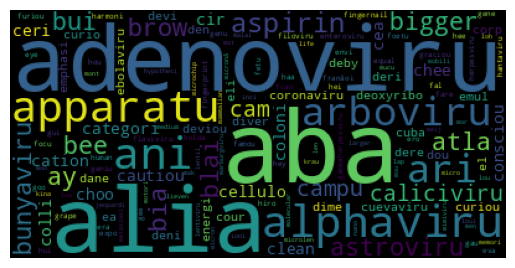

In [38]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
word_cloud =WordCloud().generate(' '.join(feature_names_list))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

In [39]:
data_df.columns

Index(['id', 'title', 'introtext', 'fulltext', 'cat_id', 'class_2', 'level',
       'cat_parent_id', 'parent_title', 'grandparent_id', 'grandparent_title',
       'title_cleaned', 'introtext_cleaned', 'fulltext_cleaned'],
      dtype='object')

In [40]:
bag_nlp_df

cat_id  cat_parent_id  grandparent_id  abil  abl  accord  across  act  \
0       1836           2100            2096     0    0       1       0    0   
1       1836           2100            2096     0    0       1       1    0   
2       1836           2100            2096     0    0       2       0    0   
3       1836           2100            2096     0    0       0       0    0   
4       1836           2100            2096     0    0       0       2    0   
...      ...            ...             ...   ...  ...     ...     ...  ...   
9145    2139           2128            2096     0    0       0       0    0   
9146    2139           2128            2096     0    0       0       0    0   
9147    2139           2128            2096     0    0       0       0    0   
9148    2149           2093            2096     0    0       0       0    0   
9149    2149           2093            2096     1    0       0       0    0   

      activ  actual  ...  wide  within  without  work  world  would  year  \
0         0       0  ...     0       0        3     0      0      0     0   
1         0       0  ...     1       0        1     0      1      0     1   
2         0       0  ...     0       0        0     0      0      0     0   
3         0       0  ...     0       0        0     0      2      0     0   
4         0       0  ...     0       0        0     0      0      0     0   
...     ...     ...  ...   ...     ...      ...   ...    ...    ...   ...   
9145      0       0  ...     0       2        2     0      0      1     0   
9146      0       1  ...     0       0        0     4      1      1     1   
9147      0       0  ...     0       0        0     0      0      1     0   
9148      0       0  ...     0       0        1     0      0      0     1   
9149      0       0  ...     0       0        0     1      0      0     0   

      yet  âthe  âwe  
0       0     0    0  
1       0     0    0  
2       0     0    0  
3       0     0    0  
4       0     0    0  
...   ...   ...  ...  
9145    0     0    0  
9146    0     0    0  
9147    0     0    0  
9148    0     0    0  
9149    0     0    0  

[9150 rows x 436 columns]

In [41]:
bag_nlp_df['kmeans']=results['Hierarchical']
bag_nlp_df.head()

cat_id  cat_parent_id  grandparent_id  abil  abl  accord  across  act  \
0    1836           2100            2096     0    0       1       0    0   
1    1836           2100            2096     0    0       1       1    0   
2    1836           2100            2096     0    0       2       0    0   
3    1836           2100            2096     0    0       0       0    0   
4    1836           2100            2096     0    0       0       2    0   

   activ  actual  ...  within  without  work  world  would  year  yet  âthe  \
0      0       0  ...       0        3     0      0      0     0    0     0   
1      0       0  ...       0        1     0      1      0     1    0     0   
2      0       0  ...       0        0     0      0      0     0    0     0   
3      0       0  ...       0        0     0      2      0     0    0     0   
4      0       0  ...       0        0     0      0      0     0    0     0   

   âwe  kmeans  
0    0       8  
1    0       8  
2    0       8  
3    0       8  
4    0       8  

[5 rows x 437 columns]

In [42]:
bag_nlp_df.to_csv('final_data.csv')

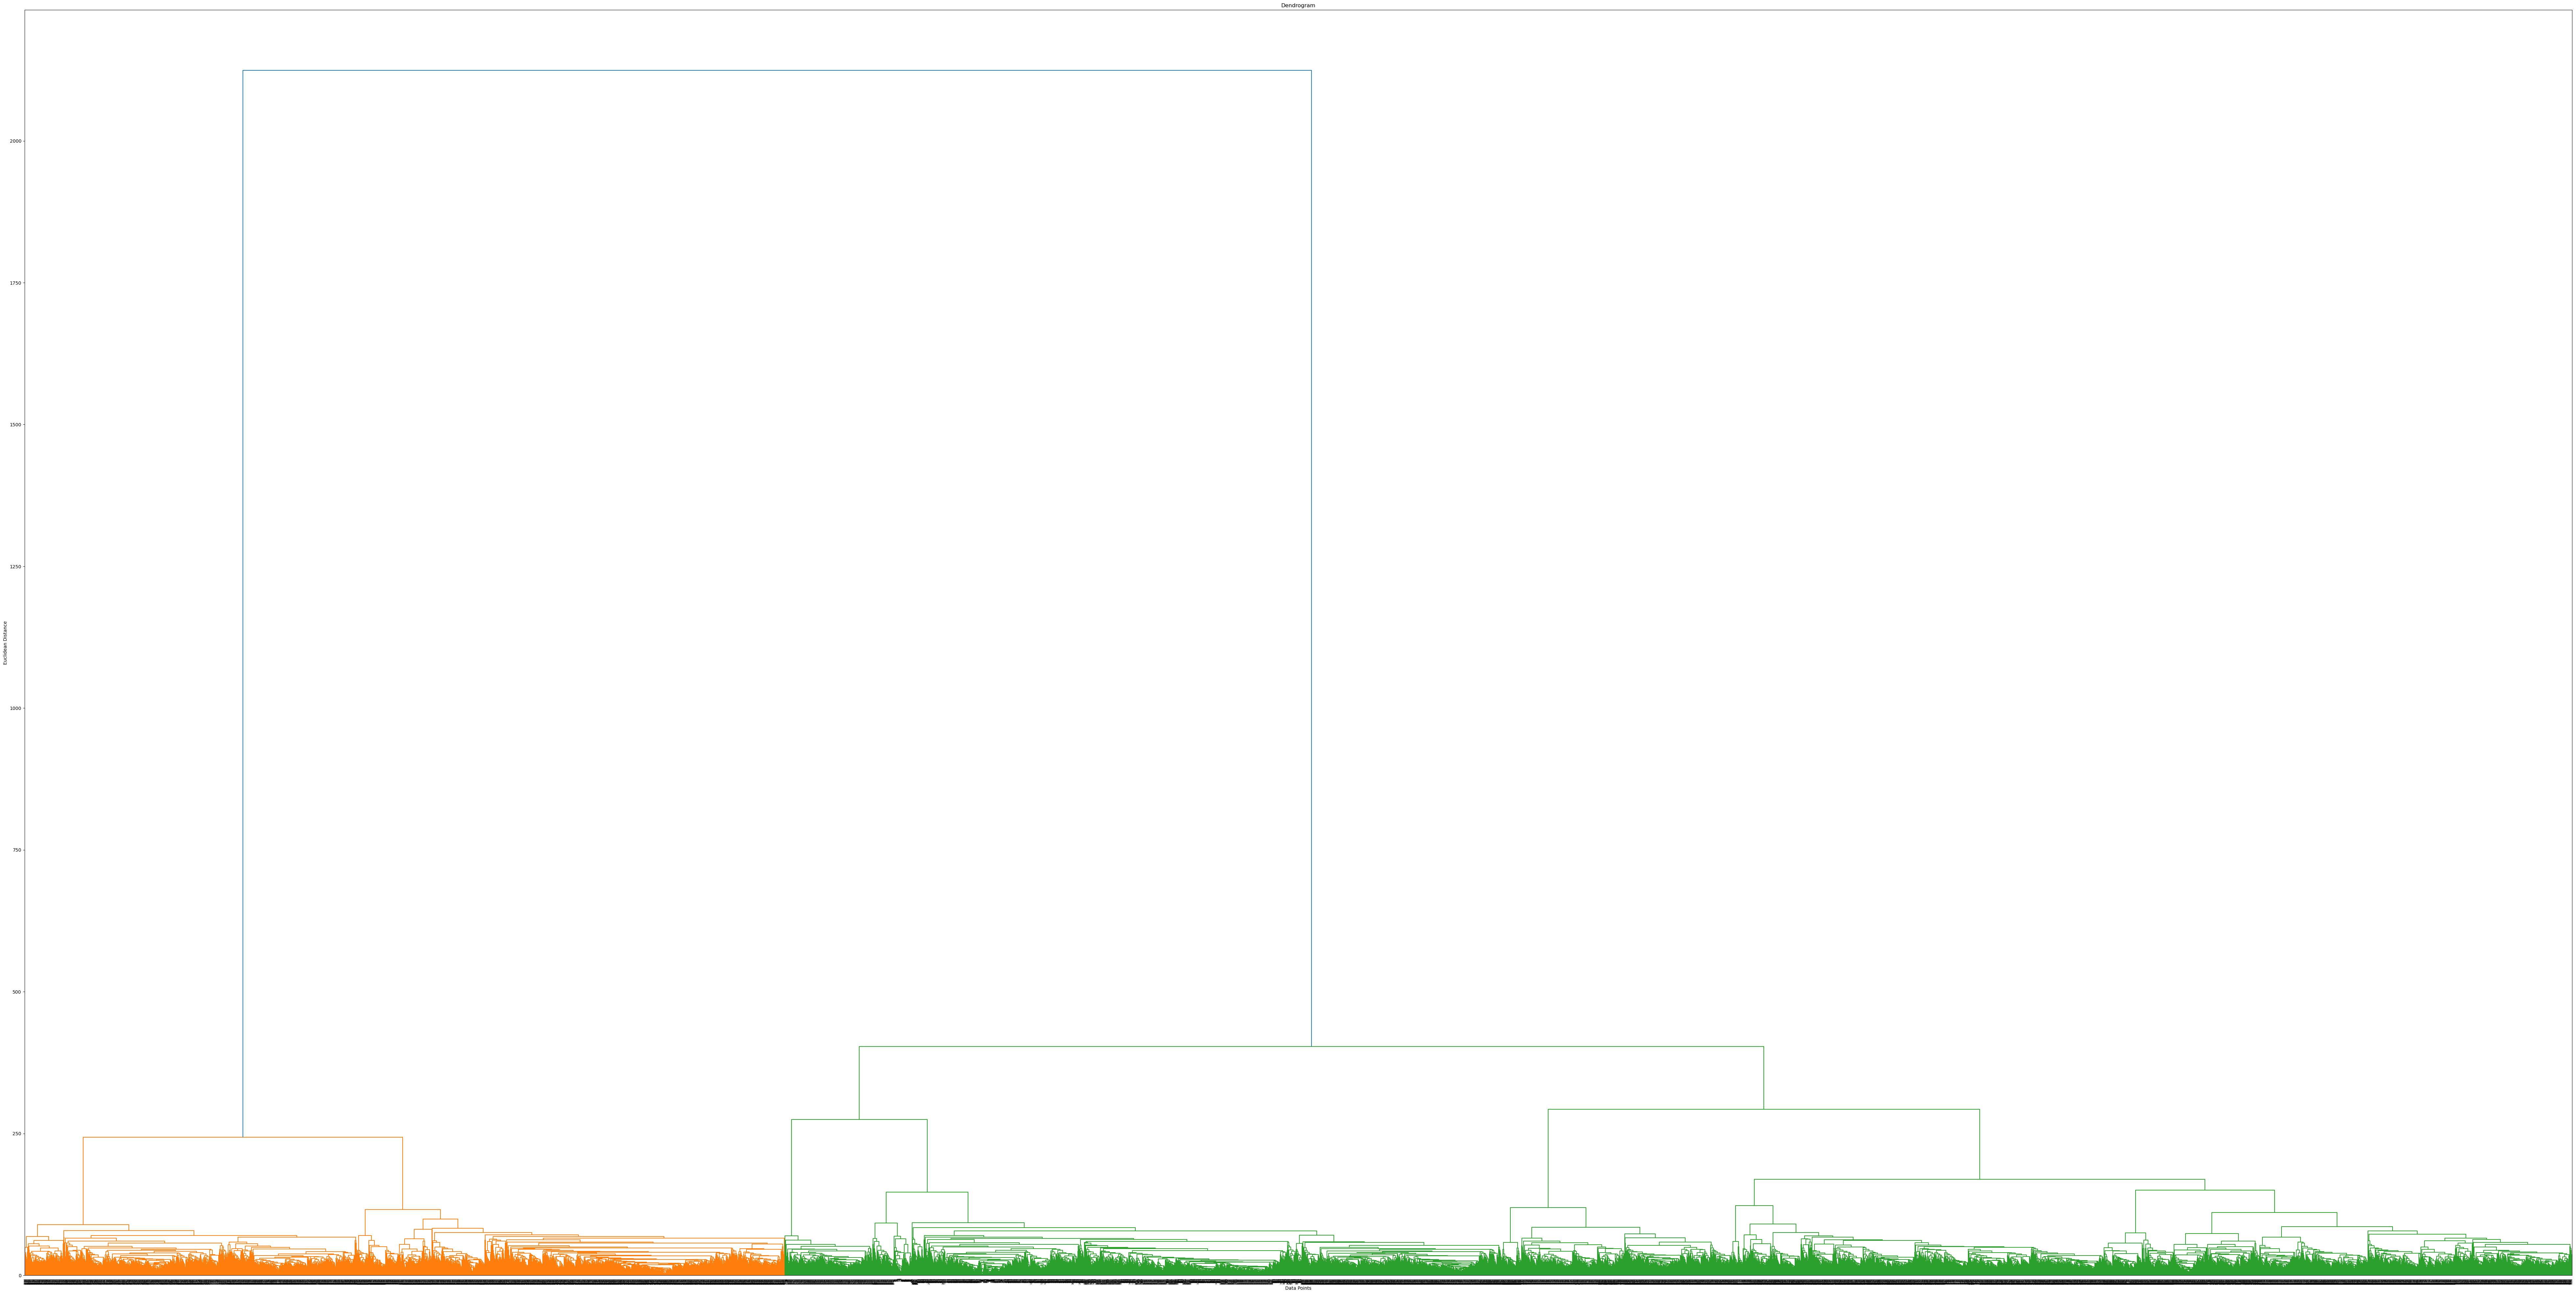

In [43]:
from scipy.cluster.hierarchy import dendrogram, linkage
bag_nlp_df_temp = bag_nlp_df.copy(deep=True)
linked = linkage(bag_nlp_df_temp,'complete')

plt.figure(figsize=(100, 50))
dendrogram(linked)
plt.title('Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distance')
plt.show()

In [44]:
# import pandas as pd
# import dash_bio

# dash_bio.Clustergram(
#     data=bag_nlp_df,
#     column_labels=list(bag_nlp_df.columns.values),
#     row_labels=list(bag_nlp_df.index),
#     display_ratio=[0.1, 0.7]
# )

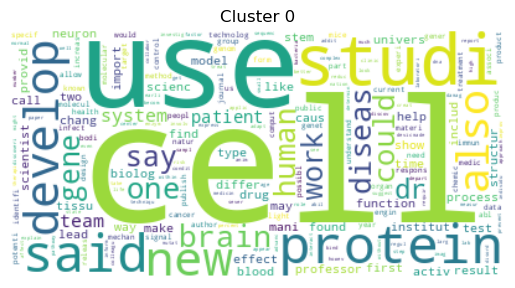

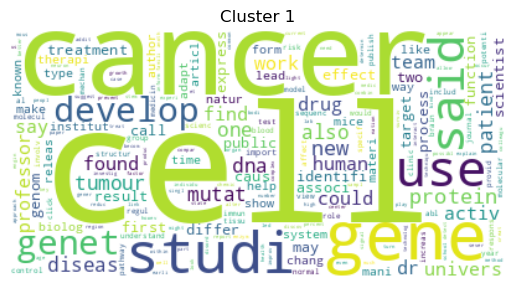

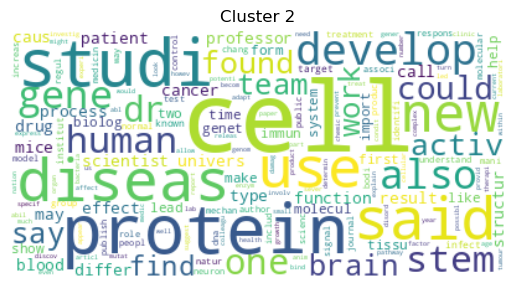

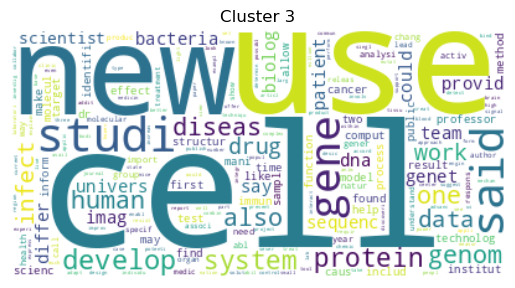

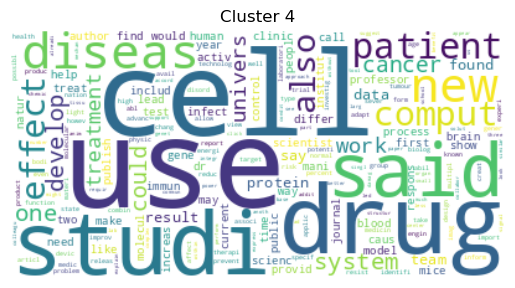

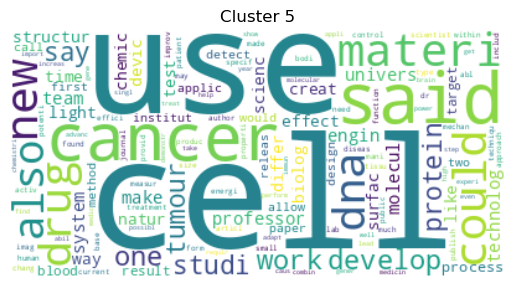

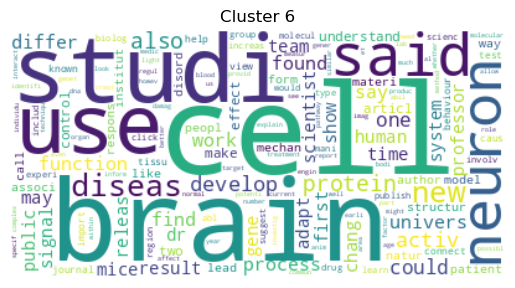

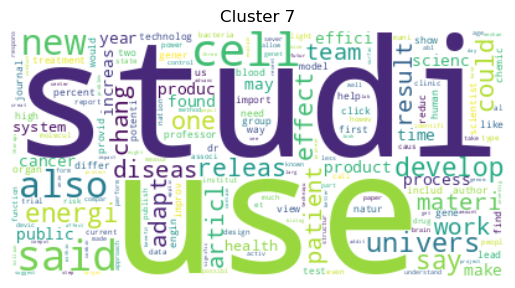

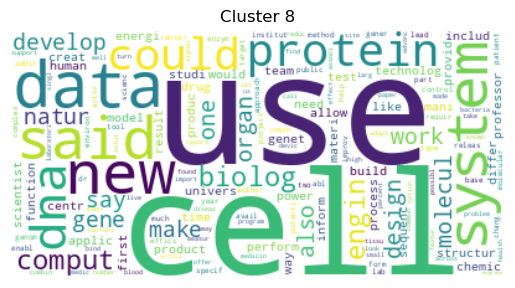

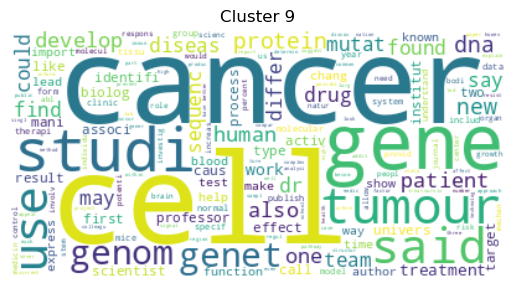

In [45]:
temp = bag_nlp_df.drop(columns=['cat_id', 'level','cat_parent_id','grandparent_id'])
grouped = temp.groupby('kmeans').sum()
for cluster, row in grouped.iterrows():
    words = {}
    for word, value in row.iteritems():
        words[word] = value
    
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(words)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Cluster {cluster}")
    plt.show()

In [46]:
bag_nlp_df = pd.concat([data_df[['cat_id','parent_title','grandparent_id']], df_bow_sklearn], axis=1)
bag_nlp_df.shape

(9150, 436)

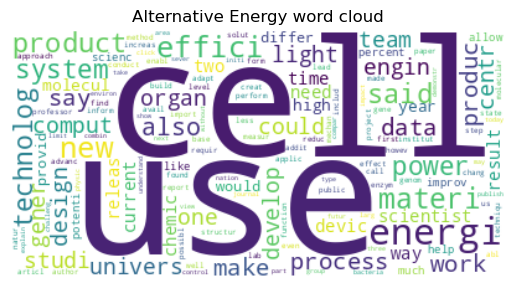

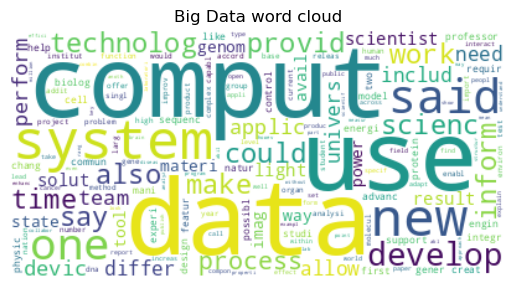

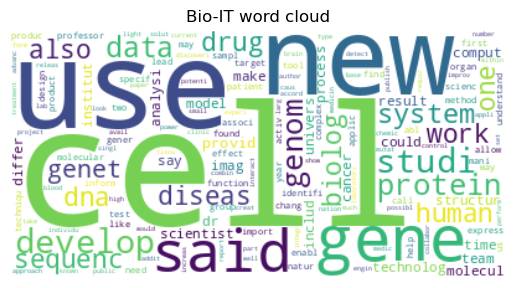

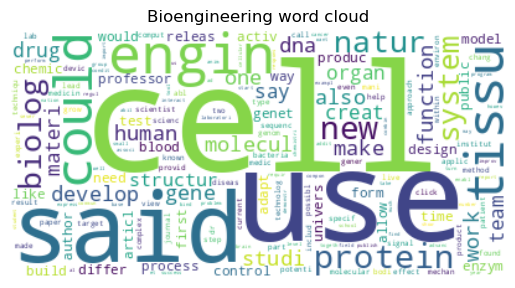

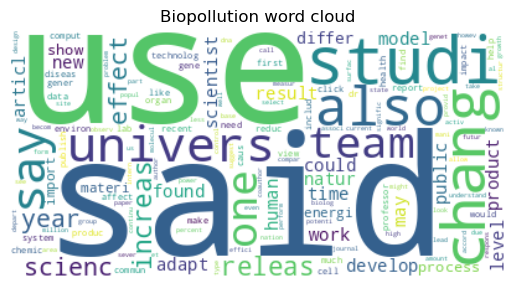

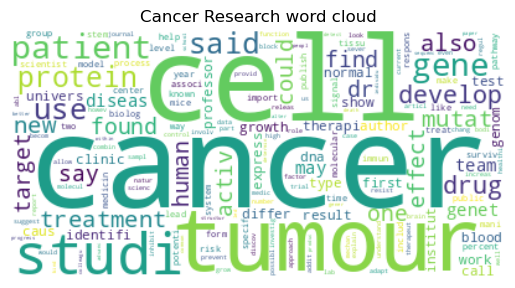

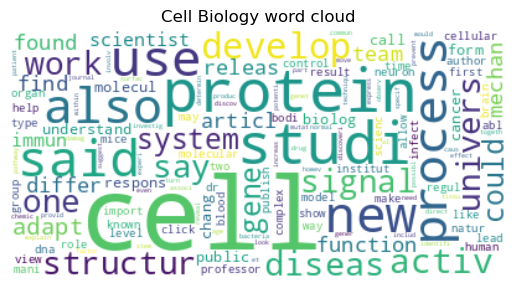

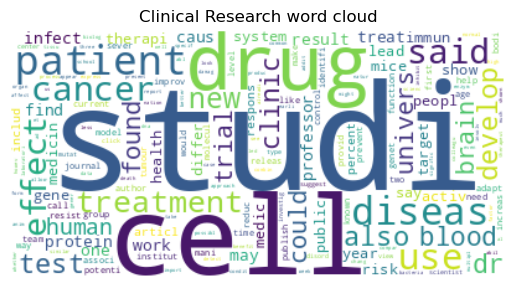

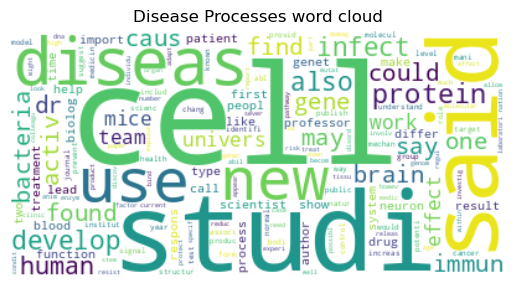

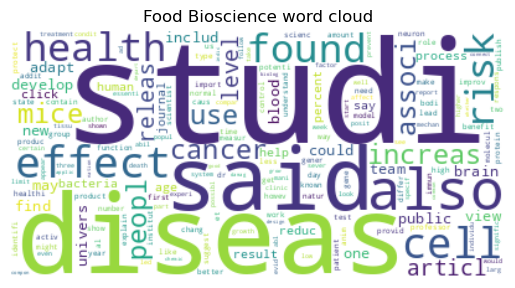

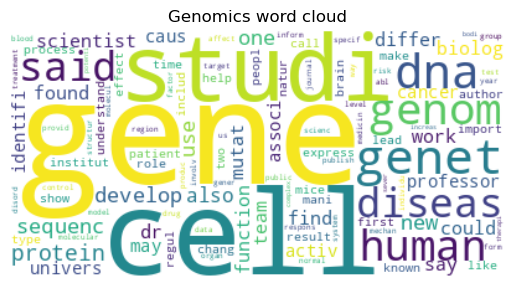

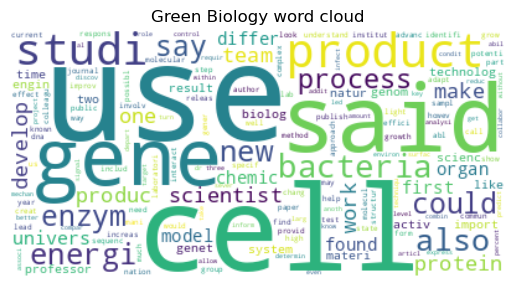

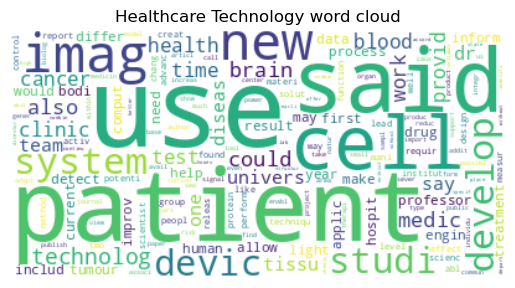

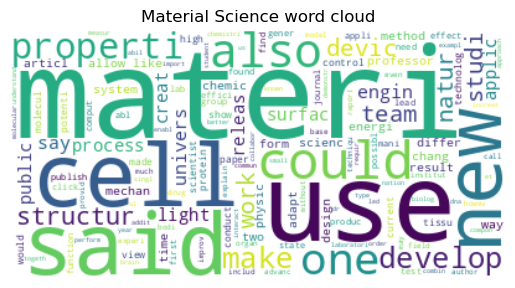

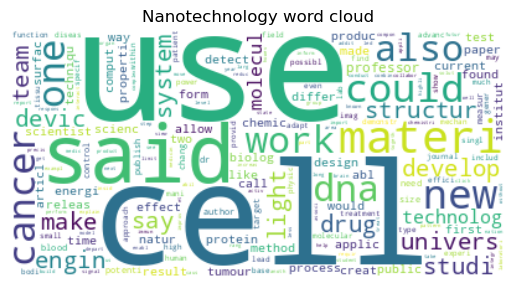

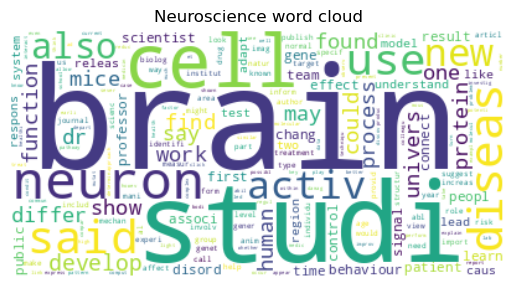

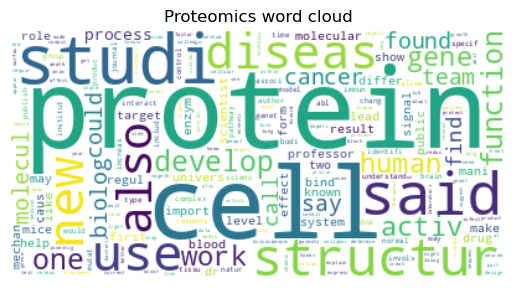

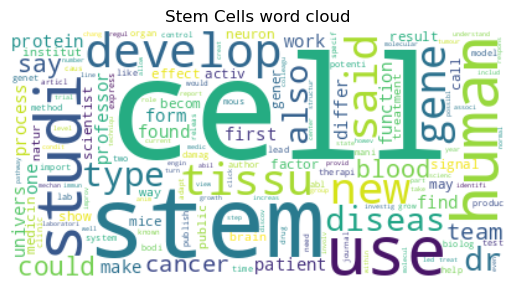

In [47]:
temp = bag_nlp_df.drop(columns=['grandparent_id','cat_id'])
grouped = temp.groupby('parent_title').sum()
for cluster, row in grouped.iterrows():
    words = {}
    for word, value in row.iteritems():
        words[word] = value
    
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(words)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{cluster} word cloud")
    plt.show()

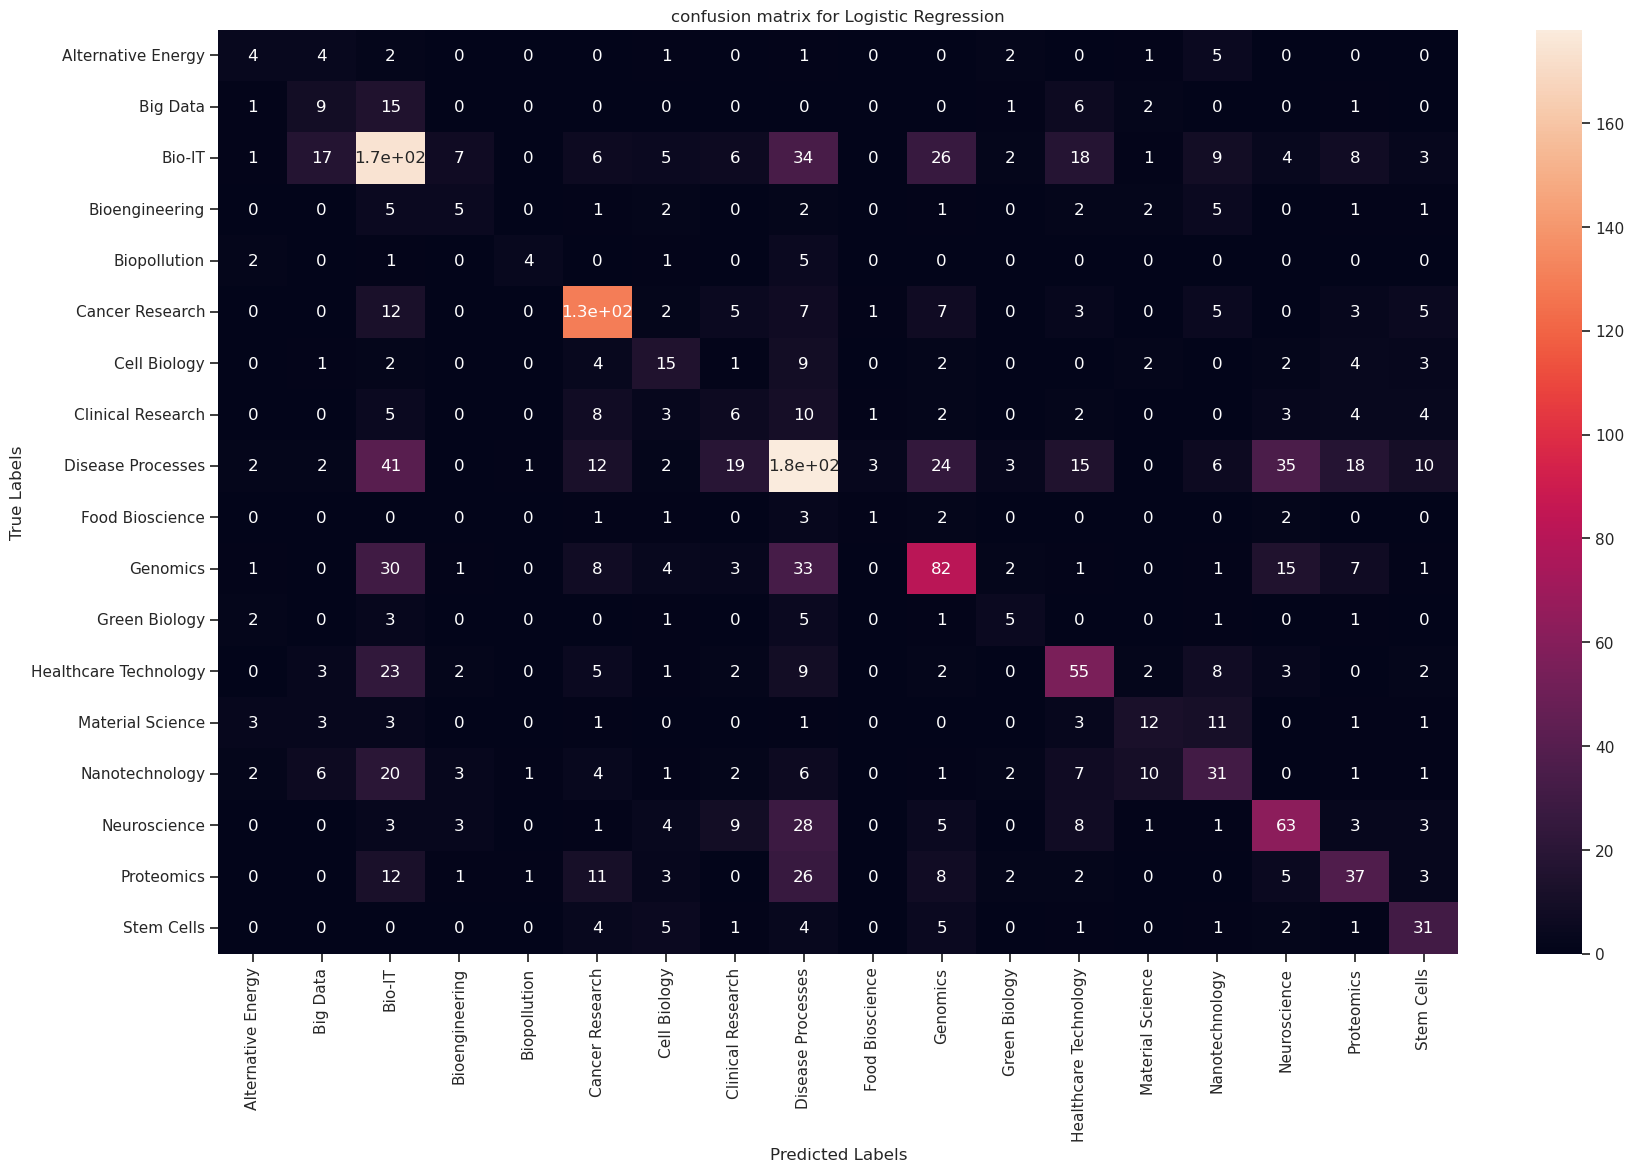

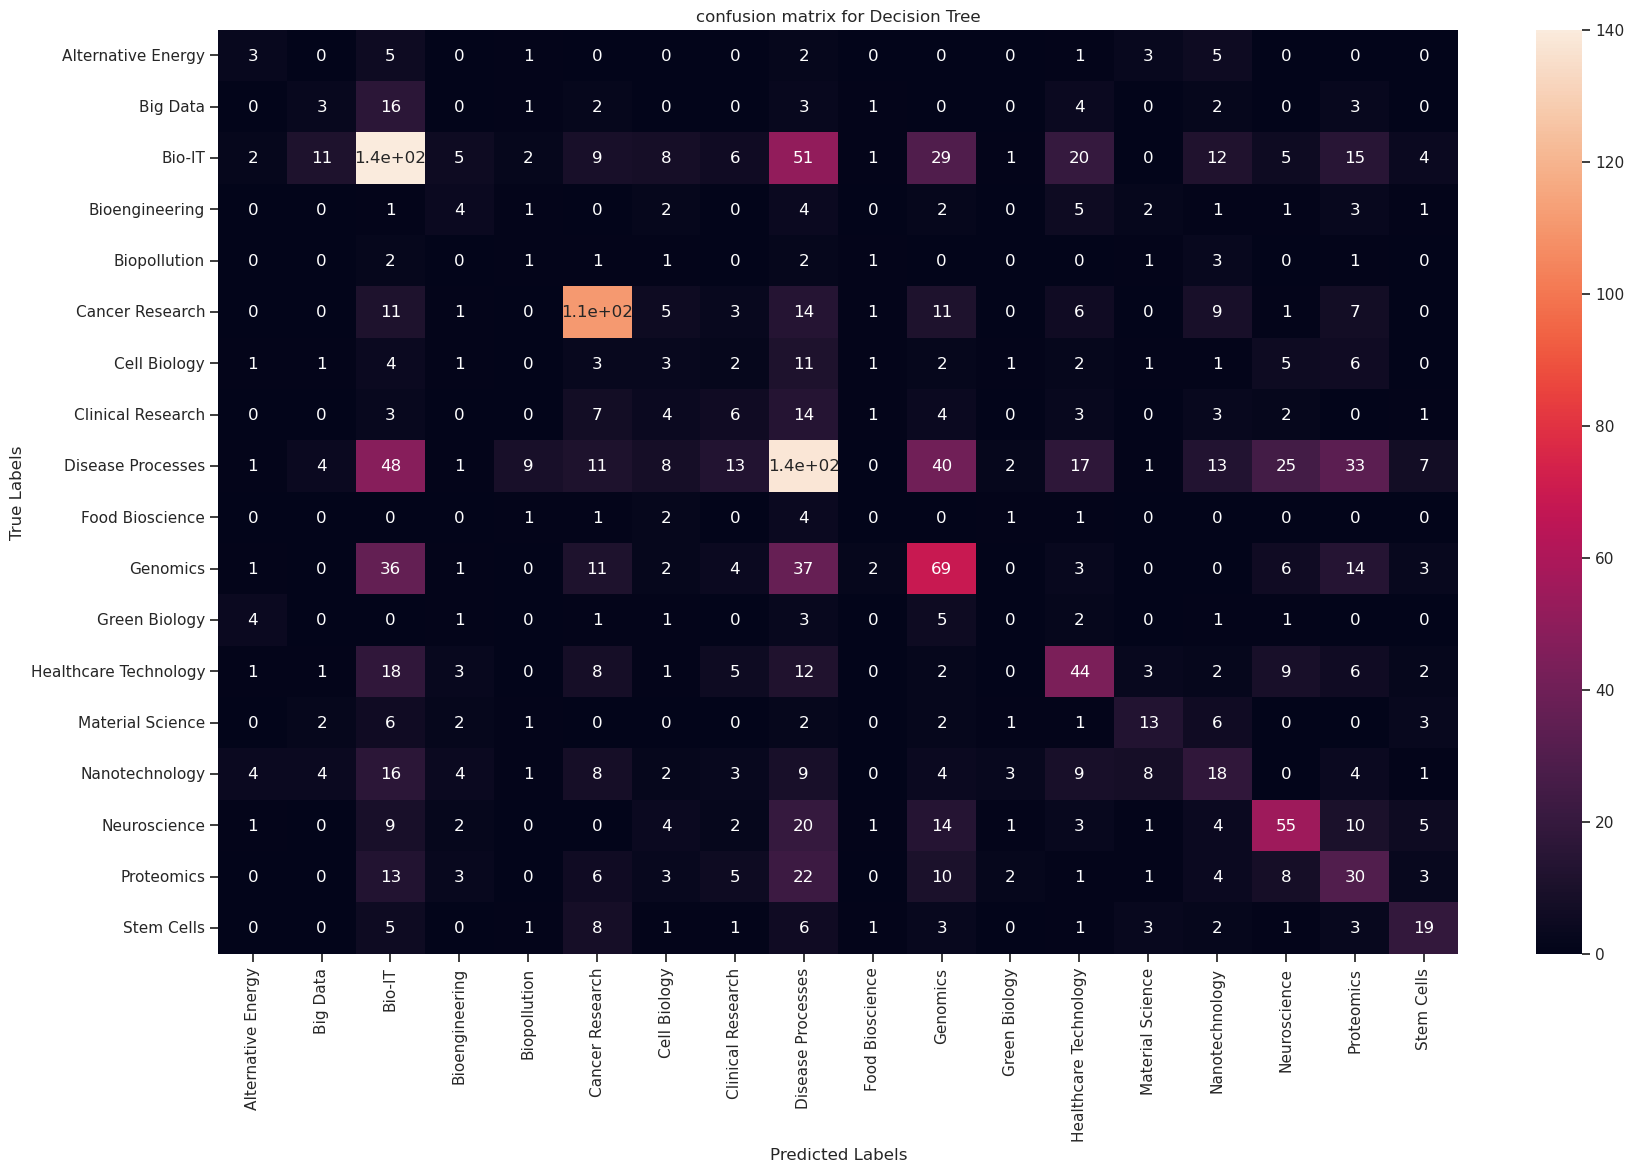

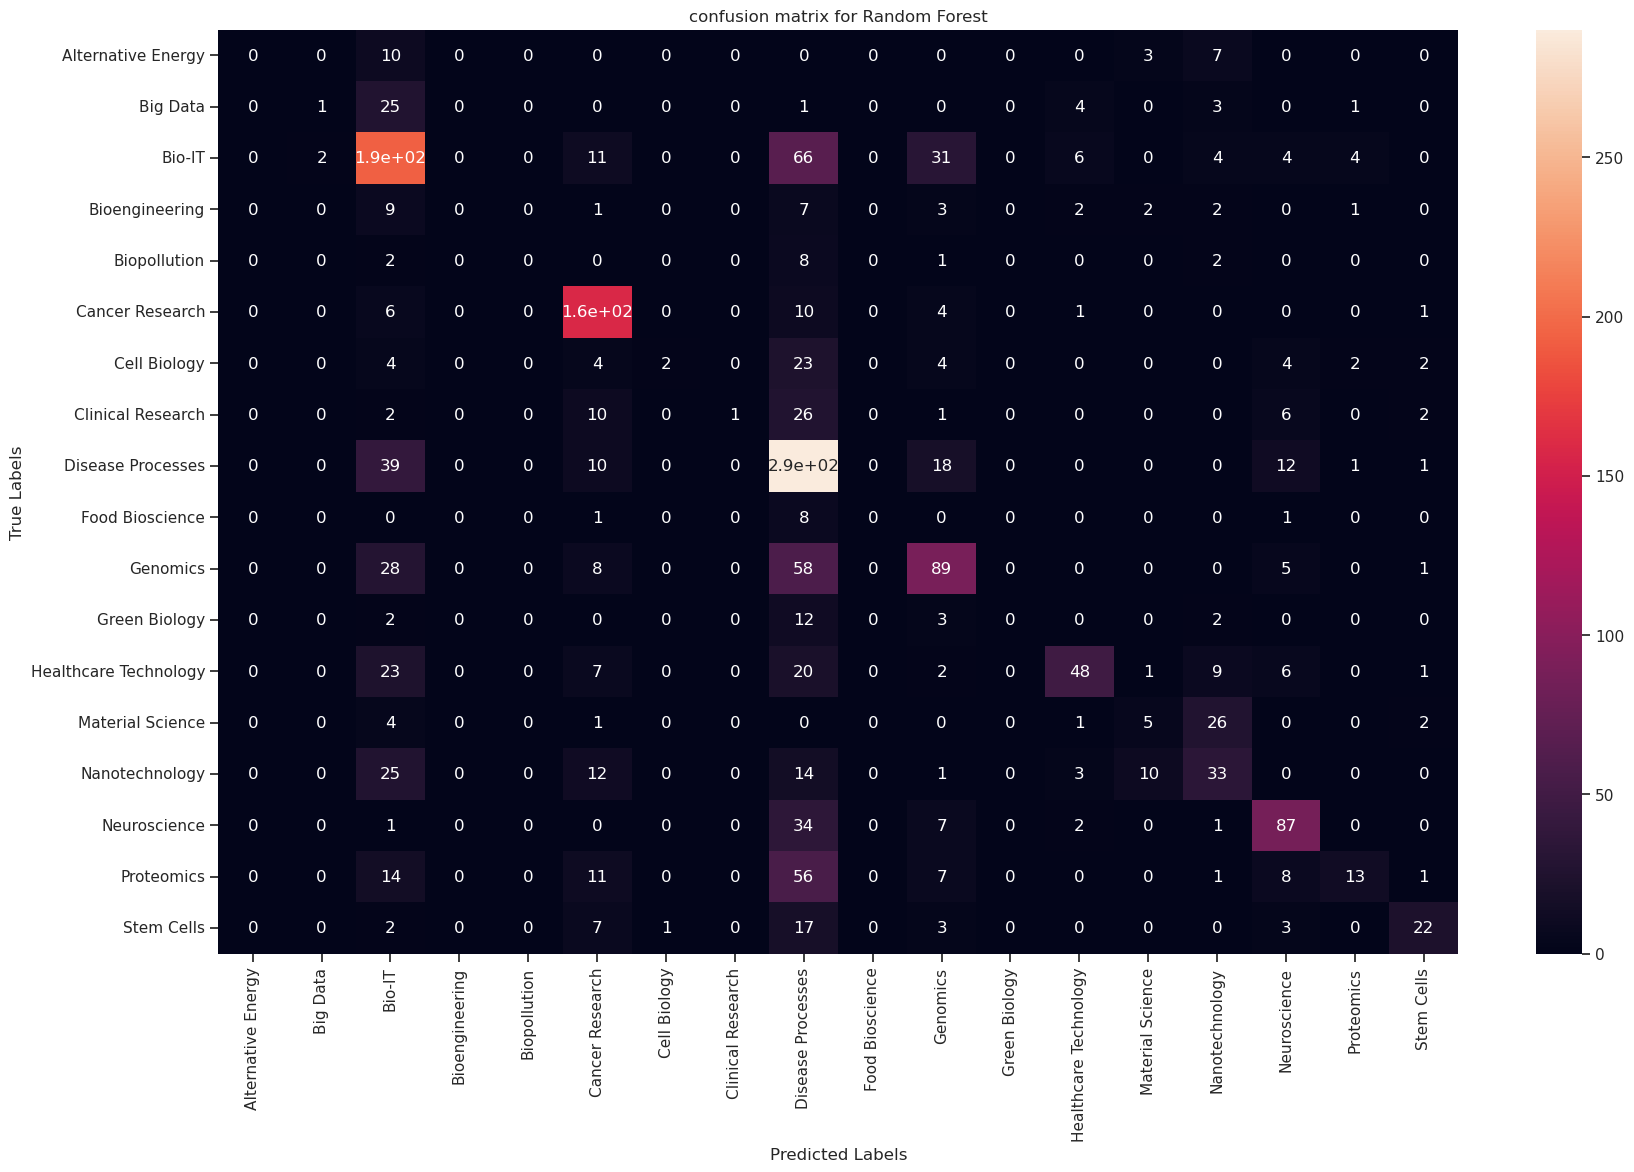

In [48]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
sns.set_theme(style="ticks")
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelBinarizer

# Assuming data is loaded as `df` and target column is 'target'
# Convert the target to string if they're not
bag_nlp_df['parent_title'] = bag_nlp_df['parent_title'].astype(str)

y = bag_nlp_df['parent_title']
X = bag_nlp_df.drop(columns=['parent_title','cat_id', 'grandparent_id'])

# Count the instances of each class
class_counts = y.value_counts()

# Find the classes that have at least 2 instances
valid_classes = class_counts[class_counts >= 2].index.sort_values()

# Filter the data to only include these classes
y = y[y.isin(valid_classes)]
X = X.loc[y.index]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y)

# Binarize target for ROC
lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)
y_test_bin = lb.transform(y_test)
# Initialize classifiers
classifiers = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier())
]

# Data Collection
metrics_data = []
roc_data = []

# Model Training, Prediction & Metric Calculation
for name, clf in classifiers:
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    report = classification_report(y_test, predictions, output_dict=True, zero_division=1)
    # Confusion Matrix
    plt.figure(figsize = (20,12))
    sns.heatmap(confusion_matrix(y_test, predictions), annot = True, xticklabels = valid_classes, yticklabels = valid_classes)
    plt.title('confusion matrix for '+name )
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig('confusion matrix for '+name , bbox_inches='tight')
    plt.show()
    
    
    # Collecting metrics data
    for target_class in list(set(y_test.values)):
        metrics_data.append((name, target_class, report[target_class]['precision'], report[target_class]['recall'], report[target_class]['f1-score']))
        
    # ROC and AUC for multi-class (One-vs-All approach)
    y_prob = clf.predict_proba(X_test)
    for idx, target_class in enumerate(list(set(y_test.values))):
        fpr, tpr, _ = roc_curve(y_test_bin[:, idx], y_prob[:, idx])
        auc = roc_auc_score(y_test_bin[:, idx], y_prob[:, idx])
        roc_data.append((name, target_class, fpr, tpr, auc))
        
# Convert results to DataFrame for visualization
df_metrics = pd.DataFrame(metrics_data, columns=["Classifier", "Class", "Precision", "Recall", "F1-Score"])

# Visualizations
# Bar charts for metrics
fig = px.bar(df_metrics, x="Classifier", y=["Precision", "Recall", "F1-Score"], color="Class", barmode="group", title="Classification Metrics Comparison")
fig.show()

# ROC Curves
fig = go.Figure()
for name, target_class, fpr, tpr, auc in roc_data:
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=f'{name} - Class {target_class} (AUC: {auc:.2f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Baseline', line=dict(dash='dash')))
fig.update_layout(title="ROC Curve", xaxis_title="False Positive Rate", yaxis_title="True Positive Rate", xaxis=dict(scaleanchor="y", scaleratio=1), yaxis=dict(scaleanchor="x", scaleratio=1))
fig.show()

In [49]:
roc_data

[('Logistic Regression',
  'Nanotechnology',
  array([0.00000000e+00, 5.52486188e-04, 1.10497238e-03, 1.10497238e-03,
         1.65745856e-03, 1.65745856e-03, 3.86740331e-03, 3.86740331e-03,
         1.04972376e-02, 1.04972376e-02, 1.38121547e-02, 1.38121547e-02,
         1.93370166e-02, 1.93370166e-02, 2.20994475e-02, 2.20994475e-02,
         2.37569061e-02, 2.37569061e-02, 2.87292818e-02, 2.87292818e-02,
         2.98342541e-02, 2.98342541e-02, 3.81215470e-02, 3.81215470e-02,
         5.13812155e-02, 5.13812155e-02, 5.69060773e-02, 5.69060773e-02,
         7.51381215e-02, 7.51381215e-02, 1.35359116e-01, 1.35359116e-01,
         1.40331492e-01, 1.40331492e-01, 3.34806630e-01, 3.34806630e-01,
         3.36464088e-01, 3.36464088e-01, 1.00000000e+00]),
  array([0.  , 0.  , 0.  , 0.05, 0.05, 0.15, 0.15, 0.2 , 0.2 , 0.25, 0.25,
         0.35, 0.35, 0.4 , 0.4 , 0.45, 0.45, 0.5 , 0.5 , 0.55, 0.55, 0.6 ,
         0.6 , 0.65, 0.65, 0.7 , 0.7 , 0.75, 0.75, 0.8 , 0.8 , 0.85, 0.85,
         0.9 ,

In [50]:
df_metrics[df_metrics['Classifier']=='Logistic Regression']

Classifier                  Class  Precision    Recall  F1-Score
0   Logistic Regression         Nanotechnology   0.369048  0.316327  0.340659
1   Logistic Regression           Cell Biology   0.294118  0.333333  0.312500
2   Logistic Regression         Bioengineering   0.227273  0.185185  0.204082
3   Logistic Regression  Healthcare Technology   0.447154  0.470085  0.458333
4   Logistic Regression               Big Data   0.200000  0.257143  0.225000
5   Logistic Regression     Alternative Energy   0.222222  0.200000  0.210526
6   Logistic Regression       Material Science   0.363636  0.307692  0.333333
7   Logistic Regression        Food Bioscience   0.166667  0.100000  0.125000
8   Logistic Regression           Biopollution   0.571429  0.307692  0.400000
9   Logistic Regression                 Bio-IT   0.495726  0.542056  0.517857
10  Logistic Regression             Proteomics   0.411111  0.333333  0.368159
11  Logistic Regression      Clinical Research   0.111111  0.125000  0.117647
12  Logistic Regression        Cancer Research   0.663265  0.722222  0.691489
13  Logistic Regression             Stem Cells   0.455882  0.563636  0.504065
14  Logistic Regression          Green Biology   0.263158  0.263158  0.263158
15  Logistic Regression               Genomics   0.488095  0.433862  0.459384
16  Logistic Regression           Neuroscience   0.470149  0.477273  0.473684
17  Logistic Regression      Disease Processes   0.493075  0.479784  0.486339

In [51]:
df_metrics[df_metrics['Classifier']=="Decision Tree"]

Classifier                  Class  Precision    Recall  F1-Score
18  Decision Tree         Nanotechnology   0.209302  0.183673  0.195652
19  Decision Tree           Cell Biology   0.063830  0.066667  0.065217
20  Decision Tree         Bioengineering   0.142857  0.148148  0.145455
21  Decision Tree  Healthcare Technology   0.357724  0.376068  0.366667
22  Decision Tree               Big Data   0.115385  0.085714  0.098361
23  Decision Tree     Alternative Energy   0.166667  0.150000  0.157895
24  Decision Tree       Material Science   0.351351  0.333333  0.342105
25  Decision Tree        Food Bioscience   0.000000  0.000000  0.000000
26  Decision Tree           Biopollution   0.052632  0.076923  0.062500
27  Decision Tree                 Bio-IT   0.420420  0.436137  0.428135
28  Decision Tree             Proteomics   0.222222  0.270270  0.243902
29  Decision Tree      Clinical Research   0.120000  0.125000  0.122449
30  Decision Tree        Cancer Research   0.593583  0.616667  0.604905
31  Decision Tree             Stem Cells   0.387755  0.345455  0.365385
32  Decision Tree          Green Biology   0.000000  0.000000  0.000000
33  Decision Tree               Genomics   0.350254  0.365079  0.357513
34  Decision Tree           Neuroscience   0.462185  0.416667  0.438247
35  Decision Tree      Disease Processes   0.389831  0.371968  0.380690

In [52]:
df_metrics[df_metrics['Classifier']=="Random Forest"]

Classifier                  Class  Precision    Recall  F1-Score
36  Random Forest         Nanotechnology   0.366667  0.336735  0.351064
37  Random Forest           Cell Biology   0.666667  0.044444  0.083333
38  Random Forest         Bioengineering   1.000000  0.000000  0.000000
39  Random Forest  Healthcare Technology   0.716418  0.410256  0.521739
40  Random Forest               Big Data   0.333333  0.028571  0.052632
41  Random Forest     Alternative Energy   1.000000  0.000000  0.000000
42  Random Forest       Material Science   0.238095  0.128205  0.166667
43  Random Forest        Food Bioscience   1.000000  0.000000  0.000000
44  Random Forest           Biopollution   1.000000  0.000000  0.000000
45  Random Forest                 Bio-IT   0.496144  0.601246  0.543662
46  Random Forest             Proteomics   0.590909  0.117117  0.195489
47  Random Forest      Clinical Research   1.000000  0.020833  0.040816
48  Random Forest        Cancer Research   0.655602  0.877778  0.750594
49  Random Forest             Stem Cells   0.666667  0.400000  0.500000
50  Random Forest          Green Biology   1.000000  0.000000  0.000000
51  Random Forest               Genomics   0.511494  0.470899  0.490358
52  Random Forest           Neuroscience   0.639706  0.659091  0.649254
53  Random Forest      Disease Processes   0.446154  0.781671  0.568071

In [53]:
len(y_prob),y_prob[0]

(1830,
 array([0.02, 0.  , 0.27, 0.  , 0.01, 0.03, 0.02, 0.  , 0.23, 0.  , 0.24,
        0.01, 0.03, 0.  , 0.05, 0.01, 0.06, 0.02]))

In [54]:
results

{'KMeans': array([1, 1, 1, ..., 1, 1, 1], dtype=int32),
 'SpectralClustering': array([1, 1, 1, ..., 1, 0, 0], dtype=int32),
 'Hierarchical': array([8, 8, 8, ..., 7, 7, 7]),
 'DBSCAN': array([-1, -1, -1, ..., -1, -1, -1]),
 'HDBSCAN': array([8, 8, 8, ..., 3, 3, 3])}

In [55]:
report

{'Alternative Energy': {'precision': 1.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 20},
 'Big Data': {'precision': 0.3333333333333333,
  'recall': 0.02857142857142857,
  'f1-score': 0.05263157894736842,
  'support': 35},
 'Bio-IT': {'precision': 0.4961439588688946,
  'recall': 0.6012461059190031,
  'f1-score': 0.543661971830986,
  'support': 321},
 'Bioengineering': {'precision': 1.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 27},
 'Biopollution': {'precision': 1.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 13},
 'Cancer Research': {'precision': 0.6556016597510373,
  'recall': 0.8777777777777778,
  'f1-score': 0.7505938242280285,
  'support': 180},
 'Cell Biology': {'precision': 0.6666666666666666,
  'recall': 0.044444444444444446,
  'f1-score': 0.08333333333333334,
  'support': 45},
 'Clinical Research': {'precision': 1.0,
  'recall': 0.020833333333333332,
  'f1-score': 0.04081632653061225,
  'support': 48},
 'Disease Processes': {'precision': 0.4461538461538462,

In [56]:
metrics_data

[('Logistic Regression',
  'Nanotechnology',
  0.36904761904761907,
  0.3163265306122449,
  0.34065934065934067),
 ('Logistic Regression',
  'Cell Biology',
  0.29411764705882354,
  0.3333333333333333,
  0.3125),
 ('Logistic Regression',
  'Bioengineering',
  0.22727272727272727,
  0.18518518518518517,
  0.20408163265306123),
 ('Logistic Regression',
  'Healthcare Technology',
  0.44715447154471544,
  0.4700854700854701,
  0.4583333333333333),
 ('Logistic Regression', 'Big Data', 0.2, 0.2571428571428571, 0.225),
 ('Logistic Regression',
  'Alternative Energy',
  0.2222222222222222,
  0.2,
  0.2105263157894737),
 ('Logistic Regression',
  'Material Science',
  0.36363636363636365,
  0.3076923076923077,
  0.33333333333333337),
 ('Logistic Regression', 'Food Bioscience', 0.16666666666666666, 0.1, 0.125),
 ('Logistic Regression',
  'Biopollution',
  0.5714285714285714,
  0.3076923076923077,
  0.4),
 ('Logistic Regression',
  'Bio-IT',
  0.49572649572649574,
  0.5420560747663551,
  0.517857

In [57]:
bag_nlp_df.parent_title.unique()

array(['Big Data', 'Nanotechnology', 'Alternative Energy', 'Bio-IT',
       'Healthcare Technology', 'Genomics', 'Clinical Research',
       'Disease Processes', 'Cancer Research', 'Bioengineering',
       'Green Biology', 'Proteomics', 'Stem Cells', 'Neuroscience',
       'Material Science', 'Cell Biology', 'Food Bioscience',
       'Biopollution'], dtype=object)

In [58]:
X

abil  abl  accord  across  act  activ  actual  ad  adapt  addit  ...  \
0        0    0       1       0    0      0       0   1      0      0  ...   
1        0    0       1       1    0      0       0   0      0      3  ...   
2        0    0       2       0    0      0       0   0      0      1  ...   
3        0    0       0       0    0      0       0   0      0      1  ...   
4        0    0       0       2    0      0       0   0      0      0  ...   
...    ...  ...     ...     ...  ...    ...     ...  ..    ...    ...  ...   
9145     0    0       0       0    0      0       0   0      1      0  ...   
9146     0    0       0       0    0      0       1   0      1      0  ...   
9147     0    0       0       0    0      0       0   0      1      0  ...   
9148     0    0       0       0    0      0       0   0      1      0  ...   
9149     1    0       0       0    0      0       0   0      1      0  ...   

      wide  within  without  work  world  would  year  yet  âthe  âwe  
0        0       0        3     0      0      0     0    0     0    0  
1        1       0        1     0      1      0     1    0     0    0  
2        0       0        0     0      0      0     0    0     0    0  
3        0       0        0     0      2      0     0    0     0    0  
4        0       0        0     0      0      0     0    0     0    0  
...    ...     ...      ...   ...    ...    ...   ...  ...   ...  ...  
9145     0       2        2     0      0      1     0    0     0    0  
9146     0       0        0     4      1      1     1    0     0    0  
9147     0       0        0     0      0      1     0    0     0    0  
9148     0       0        1     0      0      0     1    0     0    0  
9149     0       0        0     1      0      0     0    0     0    0  

[9150 rows x 433 columns]

In [59]:
import pandas as pd
import numpy as np
from transformers import pipeline

In [60]:
data_df = pd.read_csv('/kaggle/input/thesis-data/Nebuli_data.csv',index_col=0)
candidate_labels = list(data_df['parent_title'].unique())
data_df = data_df.head(100)
print(data_df.shape)
data_df.head()

(100, 11)


id                                              title  \
0  201               SGI Launches Open Storage Initiative   
1  270  IBM Releases Next Generation Storage Virtualis...   
2  293  IBM Launches New Mainframe and Storage Systems...   
3  337  Oracle 10g database sets the pace for a world ...   
4  339   IBM Releases New Automated DB2 Database Software   

                                           introtext  \
0  Silicon Graphics has today announced the Open ...   
1  IBM has revealed its TotalStorage SAN File Sys...   
2  Celebrating the 40th anniversary of the IBM Sy...   
3  Oracle is setting the pace for the highest per...   
4  IBM has today announced the release of its new...   

                                            fulltext  cat_id          class_2  \
0  Silicon Graphics has today announced the Open ...    1836  Data Management   
1  IBM has revealed its TotalStorage SAN File Sys...    1836  Data Management   
2   Celebrating the 40th anniversary of the IBM S...    1836  Data Management   
3   Tests were performed on an eight-node cluster...    1836  Data Management   
4   The new database software promises to deliver...    1836  Data Management   

   level  cat_parent_id parent_title  grandparent_id grandparent_title  
0      3           2100     Big Data            2096          Channels  
1      3           2100     Big Data            2096          Channels  
2      3           2100     Big Data            2096          Channels  
3      3           2100     Big Data            2096          Channels  
4      3           2100     Big Data            2096          Channels

In [61]:
%%time

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
def classify(seq):
    res = classifier(list(seq['fulltext']), candidate_labels,multi_label = True)
    df = pd.DataFrame({'labels':res[0]['labels'],'scores':res[0]['scores']})
    return df
    
df = data_df.groupby(['id','fulltext','parent_title']).apply(classify).reset_index()
df.head()

CPU times: user 4h 34min 20s, sys: 9min 53s, total: 4h 44min 14s
Wall time: 2h 23min 8s


id                                           fulltext parent_title  \
0   1  ACORRN (the Academic Clinical Oncology &amp; R...       Bio-IT   
1   1  ACORRN (the Academic Clinical Oncology &amp; R...       Bio-IT   
2   1  ACORRN (the Academic Clinical Oncology &amp; R...       Bio-IT   
3   1  ACORRN (the Academic Clinical Oncology &amp; R...       Bio-IT   
4   1  ACORRN (the Academic Clinical Oncology &amp; R...       Bio-IT   

   level_3             labels    scores  
0        0  Clinical Research  0.891404  
1        1    Cancer Research  0.800621  
2        2           Channels  0.671475  
3        3           Big Data  0.519628  
4        4  Disease Processes  0.456901

In [62]:
df.to_csv('bart_output.csv')

In [63]:
%%time

classifier = pipeline("zero-shot-classification", model="MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli")
def classify(seq):
    res = classifier(list(seq['fulltext']), candidate_labels,multi_label = True)
    df = pd.DataFrame({'labels':res[0]['labels'],'scores':res[0]['scores']})
    return df
    
df = data_df.groupby(['id','fulltext','parent_title']).apply(classify).reset_index()
df.head()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


CPU times: user 2h 15min 42s, sys: 47.9 s, total: 2h 16min 30s
Wall time: 1h 9min 4s


id                                           fulltext parent_title  \
0   1  ACORRN (the Academic Clinical Oncology &amp; R...       Bio-IT   
1   1  ACORRN (the Academic Clinical Oncology &amp; R...       Bio-IT   
2   1  ACORRN (the Academic Clinical Oncology &amp; R...       Bio-IT   
3   1  ACORRN (the Academic Clinical Oncology &amp; R...       Bio-IT   
4   1  ACORRN (the Academic Clinical Oncology &amp; R...       Bio-IT   

   level_3                 labels    scores  
0        0                 Bio-IT  0.904146  
1        1  Healthcare Technology  0.883697  
2        2               Big Data  0.832033  
3        3      Clinical Research  0.820768  
4        4        Cancer Research  0.615717

In [64]:
df.to_csv('deberta_output.csv')

In [65]:
%%time
classifier = pipeline("zero-shot-classification", model="bert-large-uncased")
def classify(seq):
    res = classifier(list(seq['fulltext']), candidate_labels,multi_label = True)
    df = pd.DataFrame({'labels':res[0]['labels'],'scores':res[0]['scores']})
    return df
    
df = data_df.groupby(['id','fulltext','parent_title']).apply(classify).reset_index()
df.head()

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


CPU times: user 2h 47min 14s, sys: 11.4 s, total: 2h 47min 25s
Wall time: 1h 24min 24s


id                                           fulltext parent_title  \
0   1  ACORRN (the Academic Clinical Oncology &amp; R...       Bio-IT   
1   1  ACORRN (the Academic Clinical Oncology &amp; R...       Bio-IT   
2   1  ACORRN (the Academic Clinical Oncology &amp; R...       Bio-IT   
3   1  ACORRN (the Academic Clinical Oncology &amp; R...       Bio-IT   
4   1  ACORRN (the Academic Clinical Oncology &amp; R...       Bio-IT   

   level_3             labels    scores  
0        0  Disease Processes  0.575585  
1        1   Material Science  0.574323  
2        2           Channels  0.571890  
3        3     Social Science  0.565320  
4        4       Biopollution  0.564571

In [66]:
df.to_csv('bert_output.csv')